First check that you have pytorch installed, instructions are here: https://pytorch.org/get-started/locally/ , prefferably do it with anaconda if you can, I think that will lead to less problems down the road if we use other libraries.

If cuda toolkit isnt available and you have an nvidia gpu try to get that too (it might be contained within anaconda pytorch package): https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html

Also note that because the dataset is large I added it to the .gitignore, you should download it from here : https://www.kaggle.com/c/cassava-leaf-disease-classification/data, and extract it into the data/ folder of the project


In [1]:
import torch
import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torchvision
import pandas as pd
import skorch


from torch import FloatTensor, LongTensor, nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets, models
from IPython.core.debugger import set_trace

%matplotlib inline

use_cuda = True
if not torch.cuda.is_available() or not use_cuda:
    print("if you have an nvidia gpu get the cuda core package")
    device = torch.device('cpu')
else:
    print("cuda is available")
    device = torch.device('cuda:0')

cuda is available


Splitting data into train and test sets and loading the validation set

In [2]:
#setting the path to the directory containing the pics
path = './data/train_images'
test_path = './data/test_images'

labelled_dataset = pd.read_csv(r'./data/train.csv')
submission = pd.read_csv(r'./data/sample_submission.csv')

with open('./data/label_num_to_disease_map.json') as f:
    mapping_dict = json.load(f)
print(mapping_dict)

#labelled_dataset = labelled_dataset.head(800) # fast debugging, comment when training for real

# Parameters 5
train, test = train_test_split(labelled_dataset, test_size=0.25, random_state=7, stratify=labelled_dataset.label)

should_match_index = 6
print(labelled_dataset.values[should_match_index])

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}
['1000910826.jpg' 2]


In [3]:
from collections import Counter

Counter(labelled_dataset.label) # counts the elements' frequency

Counter({0: 1087, 1: 2189, 2: 2386, 3: 13158, 4: 2577})

Label Cassava Bacterial Blight (CBB) appears 1087 times<br>
Label Cassava Brown Streak Disease (CBSD) appears 2189 times<br>
Label Cassava Green Mottle (CGM) appears 2386 times<br>
Label Cassava Mosaic Disease (CMD) appears 13158 times<br>
Label Healthy appears 2577 times<br>
Because the labels arent equally represented the dataset split is stratified so each split has an equal amount of a certain label
<br><br>
Create custom dataset class for the images, and a transform to be applied to these images as part of preprocessing for learning <br>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].


In [4]:
class CassavaDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

# original resolution is 800 x 600
# Parameters 5
cassava_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((600,600)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(299), #minimum is 299 for inceptionv3 224 for everything else
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # (the means and standard deviations of each of the 3 image channels)
])

train_dataset = CassavaDataset(train, path, cassava_transform )
test_dataset = CassavaDataset(test, path, cassava_transform)
valid_dataset = CassavaDataset(submission, test_path, cassava_transform)

print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))
print(len(labelled_dataset))

16047
5350
1
21397


In [5]:
train_dataset[0] # how a transformed image tensor looks like, its label is 2

(tensor([[[ 0.5878,  1.2557,  1.5810,  ..., -0.1999, -0.0287,  0.1597],
          [ 0.6563,  0.8789,  1.3584,  ..., -0.1657, -0.1143,  0.1426],
          [ 0.9474,  0.9474,  0.9988,  ..., -0.1486, -0.1314,  0.1426],
          ...,
          [-0.5253, -0.5596, -0.4739,  ...,  1.5810,  1.4954,  1.4440],
          [-0.3883, -0.4568, -0.3541,  ...,  1.5639,  1.4954,  1.5125],
          [-0.3541, -0.3712, -0.2513,  ...,  1.5639,  1.5982,  1.7352]],
 
         [[ 0.7829,  0.9580,  0.8179,  ...,  0.5378,  0.6604,  0.7304],
          [ 1.0455,  0.8004,  0.8704,  ...,  0.5553,  0.5553,  0.7129],
          [ 1.5357,  1.2381,  0.9230,  ...,  0.5378,  0.5203,  0.7479],
          ...,
          [ 0.2927,  0.2227,  0.2927,  ...,  1.3957,  1.3256,  1.2556],
          [ 0.3803,  0.2577,  0.3277,  ...,  1.4132,  1.2556,  1.1155],
          [ 0.3627,  0.2927,  0.3452,  ...,  1.4307,  1.2906,  1.1506]],
 
         [[-0.6541,  0.3742,  1.0017,  ..., -1.3687, -1.1247, -0.8807],
          [-0.8284, -0.5495,

In [6]:
# Parameters 1
n_epochs = 10 # on final training this should be high (around 30 for my desktop pc)
num_classes = 5 # 5 labels
batch_size = 28 # minimum batch size for inception v3 is 2, good general range seems to be 20 to 32
learning_rate = 0.0001

# using Adam optimizer, the max batch size for me is around 28, after that it uses too much vram (i have 8gb)
# using SGD optimizer, i can use up to 32
# using different pre processing parameters, i could get bigger batch sizes since the images would be smaller


train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = batch_size, shuffle=False, num_workers=0,pin_memory=True,drop_last=True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=0,pin_memory=True,drop_last=True)
# pin memory should be enabled if you use cuda cores to speed up transfer between cpu and gpu,
# drop last is there if the last batch contains 1 sample for inception v3 (if its not enabled for inception theres an error)
# num workers is 0 unless you're using linux or mac os x, because paralelization in windows is broken

Show an image from the dataset

Index: 2
Filename: 1000910826.jpg


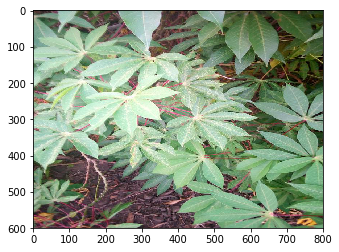

In [7]:
def show_image(index):  
    plt.imshow(img.imread('{}/{}'.format(path,labelled_dataset.values[index][0]))) # set the correct resolution here
    print('Index: {}'.format(labelled_dataset.values[index][1]))
    print('Filename: {}'.format(labelled_dataset.values[index][0]))
    
show_image(6)

Using resnet 18 pretrained pytorch model

In [8]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__) 
# Use this number below as the torchvision version or else theres a version conflict

PyTorch Version:  1.7.1
Torchvision Version:  0.2.2


Model selection below, choices are "resnet", "alexnet", "vgg", "google"

In [9]:
def get_model(model_string):
    if model_string == "google":
        net = models.inception_v3(pretrained=True) # googlenet is based on inception v1, this is improved
        net = net.cuda() if device else net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)

    if model_string == "vgg":
        net = models.vgg16(pretrained=True)
        net = net.cuda() if device else net
        net.fc = nn.Linear(4096, num_classes)

    if model_string == "alexnet":
        net = models.alexnet(pretrained=True)
        net = net.cuda() if device else net  
        net.fc = nn.Linear(4096, num_classes)

    if model_string == "resnet":
        #net = torch.hub.load('pytorch/vision:v0.2.2', 'resnet18', pretrained=True)
        net = models.resnet18(pretrained=True)
        net = net.cuda() if device else net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)
        
    net.fc = net.fc.cuda() if use_cuda else net.fc    
    return net
    
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

# Parameters 2
model_index = 0 # set model index to use here
run_all_models = True # set if it should run all models, starting with the one set above
    
string_array = ["alexnet","vgg","resnet","google"]
model_name = string_array[model_index]
net = get_model(model_name)
string_array.remove(model_name)


Do evaluation, (still have to try out parameters specified in paper, find out which are useful) <br>The original base code for the block above this text and block below was found at the following link, but it was modified for our dataset and to work with our 4 different models not just resnet: https://www.pluralsight.com/guides/introduction-to-resnet <br> <br> What I did with the models is called feature extraction, the models were all pretrained on imagenet: <br>

In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer.

In [10]:
# Will plot the accuracy of the models below and save them to a file
def plot_model_acc():
    fig = plt.figure(figsize=(20,10))
    plt.title("Train-Validation Accuracy for {}".format(model_name))
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.savefig('./plots/{}.png'.format(model_name), bbox_inches='tight')

Using model: alexnet
Epoch 1

Epoch [1/10], Step [0/573], Loss: 11.4132
Epoch [1/10], Step [57/573], Loss: 0.8695
Epoch [1/10], Step [114/573], Loss: 0.7051
Epoch [1/10], Step [171/573], Loss: 0.7191
Epoch [1/10], Step [228/573], Loss: 0.7866
Epoch [1/10], Step [285/573], Loss: 1.2118
Epoch [1/10], Step [342/573], Loss: 0.8619
Epoch [1/10], Step [399/573], Loss: 1.0366
Epoch [1/10], Step [456/573], Loss: 0.9338
Epoch [1/10], Step [513/573], Loss: 0.9549
Epoch [1/10], Step [570/573], Loss: 0.7557

train-loss: 0.9030, train-acc: 68.7983
validation loss: 0.7383, validation acc: 73.8220

Improvement-Detected, save-model
Epoch 2

Epoch [2/10], Step [0/573], Loss: 0.5707
Epoch [2/10], Step [57/573], Loss: 0.5687
Epoch [2/10], Step [114/573], Loss: 0.6402
Epoch [2/10], Step [171/573], Loss: 0.7225
Epoch [2/10], Step [228/573], Loss: 0.3220
Epoch [2/10], Step [285/573], Loss: 0.6756
Epoch [2/10], Step [342/573], Loss: 0.8467
Epoch [2/10], Step [399/573], Loss: 0.6007
Epoch [2/10], Step [456/57

validation loss: 0.5082, validation acc: 83.8444

Epoch 5

Epoch [5/10], Step [0/573], Loss: 0.5741
Epoch [5/10], Step [57/573], Loss: 0.7905
Epoch [5/10], Step [114/573], Loss: 0.2948
Epoch [5/10], Step [171/573], Loss: 0.5384
Epoch [5/10], Step [228/573], Loss: 0.6467
Epoch [5/10], Step [285/573], Loss: 0.5728
Epoch [5/10], Step [342/573], Loss: 0.2775
Epoch [5/10], Step [399/573], Loss: 0.5315
Epoch [5/10], Step [456/573], Loss: 0.5448
Epoch [5/10], Step [513/573], Loss: 0.3038
Epoch [5/10], Step [570/573], Loss: 0.3416

train-loss: 0.5571, train-acc: 84.8542
validation loss: 0.4957, validation acc: 85.1346

Improvement-Detected, save-model
Epoch 6

Epoch [6/10], Step [0/573], Loss: 0.3249
Epoch [6/10], Step [57/573], Loss: 0.3439
Epoch [6/10], Step [114/573], Loss: 0.4518
Epoch [6/10], Step [171/573], Loss: 0.5416
Epoch [6/10], Step [228/573], Loss: 0.2798
Epoch [6/10], Step [285/573], Loss: 0.1975
Epoch [6/10], Step [342/573], Loss: 0.4761
Epoch [6/10], Step [399/573], Loss: 0.304

Epoch [8/10], Step [570/573], Loss: 0.2738

train-loss: 0.4432, train-acc: 86.7863
validation loss: 0.4407, validation acc: 85.3216

Epoch 9

Epoch [9/10], Step [0/573], Loss: 0.2678
Epoch [9/10], Step [57/573], Loss: 0.3973
Epoch [9/10], Step [114/573], Loss: 0.5544
Epoch [9/10], Step [171/573], Loss: 0.4100
Epoch [9/10], Step [228/573], Loss: 0.4354
Epoch [9/10], Step [285/573], Loss: 0.7713
Epoch [9/10], Step [342/573], Loss: 0.2994
Epoch [9/10], Step [399/573], Loss: 0.4394
Epoch [9/10], Step [456/573], Loss: 0.4030
Epoch [9/10], Step [513/573], Loss: 0.2282
Epoch [9/10], Step [570/573], Loss: 0.1163

train-loss: 0.4334, train-acc: 87.6278
validation loss: 0.4423, validation acc: 84.9850

Epoch 10

Epoch [10/10], Step [0/573], Loss: 0.3776
Epoch [10/10], Step [57/573], Loss: 0.6546
Epoch [10/10], Step [114/573], Loss: 0.3673
Epoch [10/10], Step [171/573], Loss: 0.3422
Epoch [10/10], Step [228/573], Loss: 0.1250
Epoch [10/10], Step [285/573], Loss: 0.2742
Epoch [10/10], Step [342/57

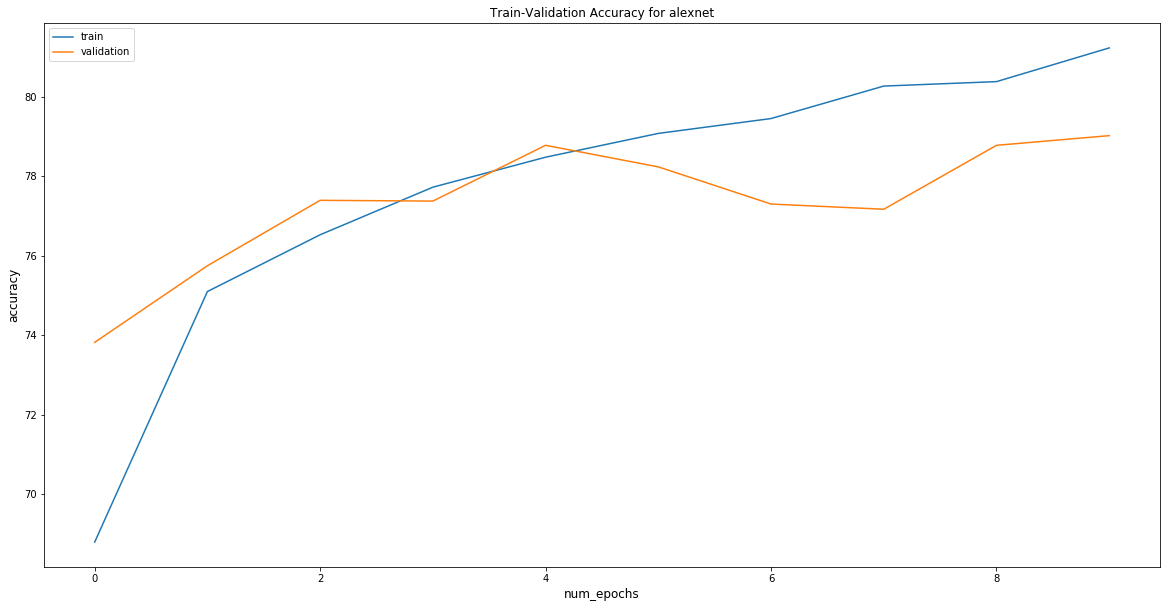

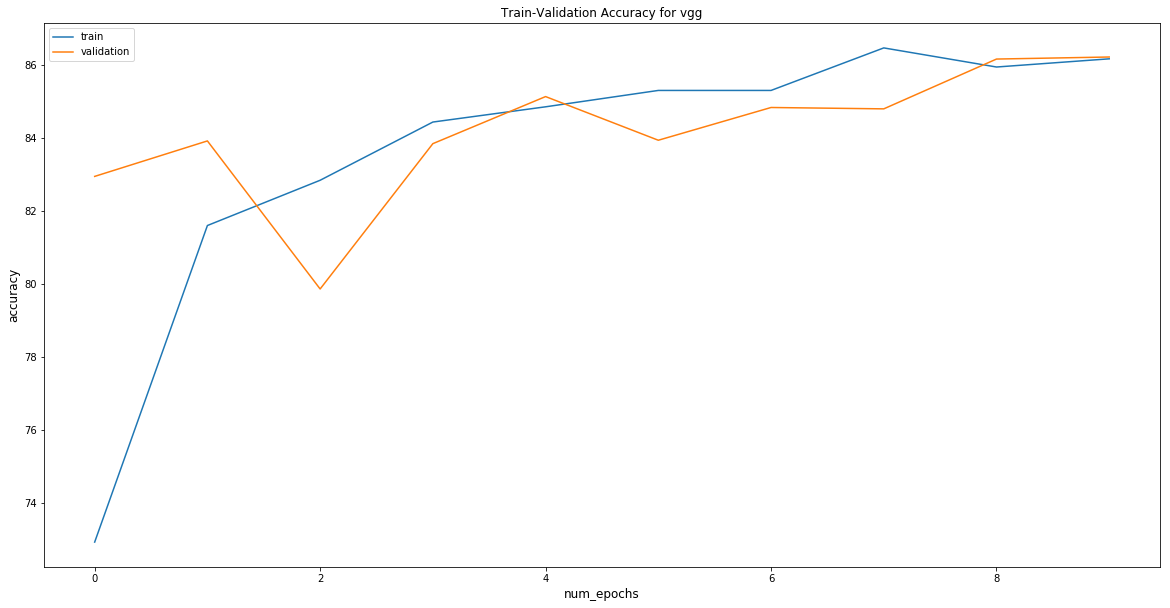

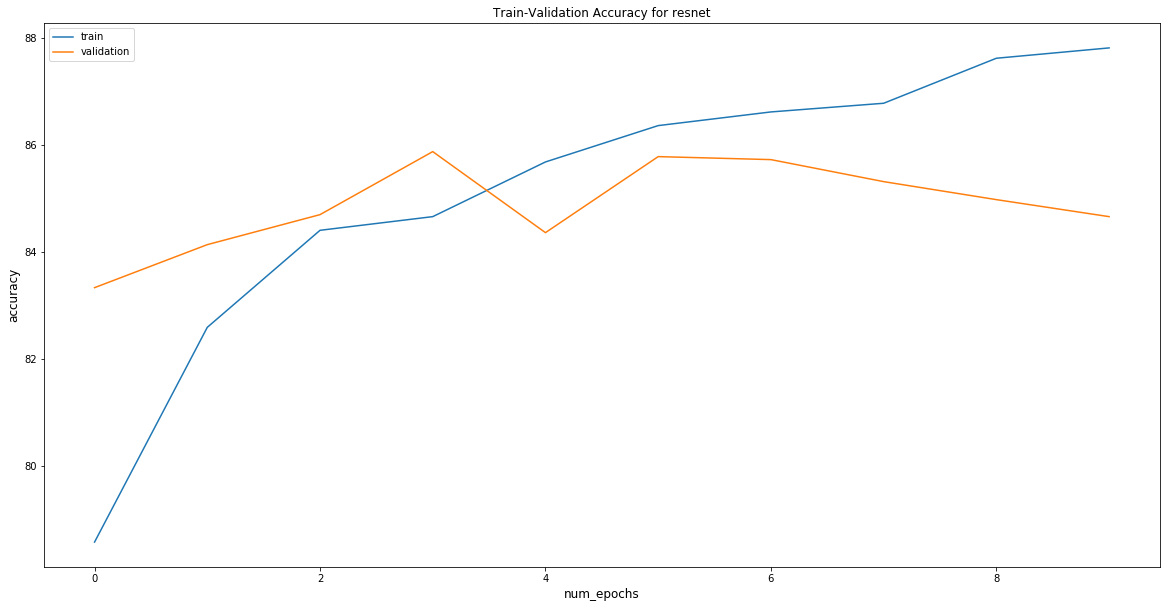

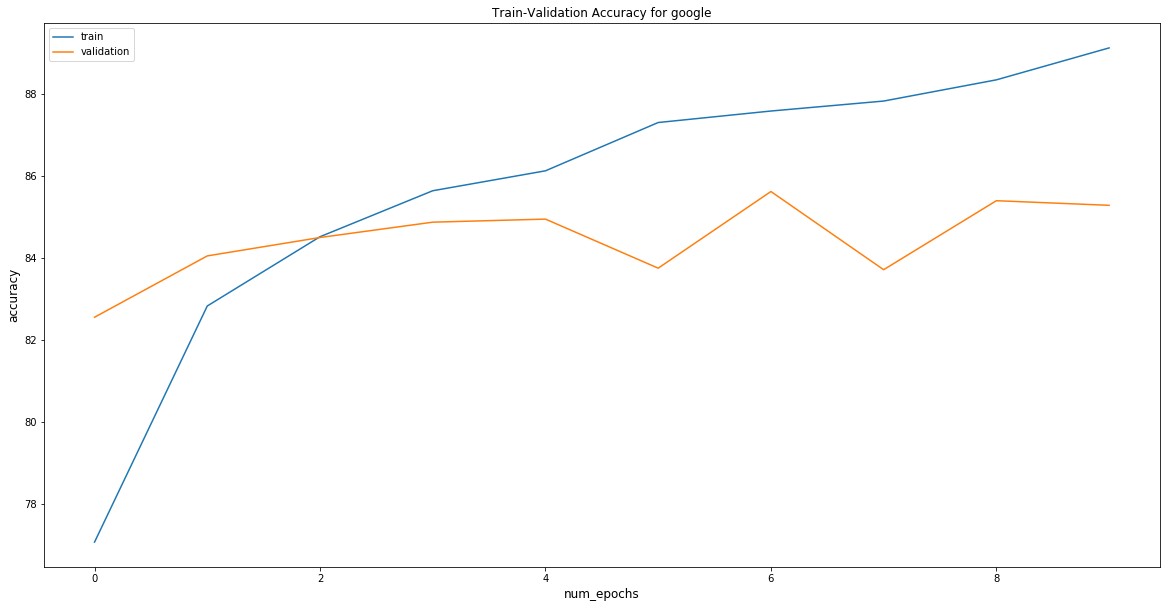

In [11]:
first_run = True
while(True):
    if(run_all_models and len(string_array) > 0):
        if not first_run:
            #Print and save graph
            plot_model_acc()
            
            del criterion # free up vram
            del optimizer
            del net
            torch.cuda.empty_cache()
            model_name = string_array.pop(0)
            net = get_model(model_name)
        else:
            first_run = False
        
        # Parameters 3
        criterion = nn.CrossEntropyLoss() # used this since we have 5 mutually exclusive classes
        #either one of the optimizers work
        #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
        
    else:
        plot_model_acc()
        break
    print("-------------------------------------------------------------------")
    print("Using model: {}".format(model_name))
    print_every = int(len(train_dataloader)*0.1) # print upon completion of every 10% of the dataset
    valid_loss_min = np.Inf
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    total_step = len(train_dataloader)
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(train_dataloader):
            data_, target_ = data_.to(device), target_.to(device)
            optimizer.zero_grad()

            outputs = net(data_)
            if model_name == "google": # for inception v3 (the google model we use): 
                # net(data_) returns logits and aux logits in a touple, we just use logits
                outputs = outputs[0]
            loss = criterion(outputs, target_)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)

            #set_trace() # Debugger entrypoint for inspecting predictions

            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            if (batch_idx) % print_every == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            net.eval()
            for data_t, target_t in (test_dataloader):
                data_t, target_t = data_t.to(device), target_t.to(device)
                outputs_t = net(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(test_dataloader))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


            if network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), './data/{}_best_model.pt'.format(model_name))
                print('Improvement-Detected, save-model')
        net.train()
        
#print(target_,pred) # used for comparing correct class vs models predictions 

Time can vary alot depending on your set parameters, cpu, gpu, whether you're using cuda etc. <br>
